# 2024 MLDL midterm
R12521521 吳竣名

In [1]:
# import those package we need 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # 引入 tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# warnings.simplefilter('ignore')
# # warnings.resetwarnings() # re-open the simple warning instead of surppressing it

# # 指定使用的字体和字号
# plt.rcParams['font.sans-serif'] = ['SimSun']  # 指定宋体字体
# plt.rcParams['font.size'] = 12  # 指定字号

## 1. Import data

In [3]:
def read_csv_file(file_name, index_col = 0):
    current_dir = os.getcwd()
    file_path = os.path.join(current_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    return pd.read_csv(file_path, index_col = index_col)

try:
    df_raw_train = read_csv_file('train.csv')
    df_raw_test = read_csv_file('X_test.csv')

    print("raw train data:", df_raw_train.shape)
    print("test data:", df_raw_test.shape)

    # X_train = df_raw_train.drop('label', axis=1)
    # y_train = df_raw_train['label'].values.reshape(-1, 1)

    # print("X_train shape:", X_train.shape)
    # print("y_train shape:", y_train.shape)

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unknown error occurred: {e}")

raw train data: (11000, 26)
test data: (2100, 25)


In [4]:
# Fraud_ratio = df_raw_train[df_raw_train['label'] == 1].shape[0]/df_raw_train.shape[0]
# print(f"The Fraud_ratio is {Fraud_ratio}")
# print(f"The Fraud number is {df_raw_train[df_raw_train['label'] == 1].shape[0]}")

我們很容易看見這是一筆 Unbalanced data 的 classification 的問題，我們可以猜測信用卡是否被盜刷，可能有許多潛在的原因是無法被既有的 data 所呈現，舉凡消費者的使用習慣以及資安意識等等，因此我認為盜刷與否會跟使用者本身有很大的關聯性，因此我們可以來檢驗看看是否被盜刷的都會集中在特定的使用者身上。

## 2. EDA on total samples / fraud samples / test data

在這個章節，我們想對我們的資料進行簡單的 EDA，但由於我們的資料大多都是類別型資料，且資料筆數非常龐大，加上 unbalanced 的影響，我們直接繪圖或許無法看出什麼。因此我們可以先針對有被盜刷過的使用者來檢查看看資料的特性，也可以從中推理出重要的解釋變數。

### 2.1 Observed data

In [5]:
# df_with_fraud = df_raw_train[df_raw_train['cano'].isin(df_raw_train[df_raw_train['label'] == 1]['cano'].unique())]
# df_with_fraud2 = df_with_fraud.groupby('cano')['label'].agg(fraud_count='sum', total_count='size').reset_index()
# df_with_fraud2['ratio'] = df_with_fraud2['fraud_count']/df_with_fraud2['total_count']
# print(f'有盜刷經驗的卡片的總資料筆數 : {df_with_fraud.shape}')
# print(f'有盜刷經驗的總卡片 : {df_with_fraud2.shape}')
# df_with_fraud2.head()

In [6]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.hist(df_with_fraud2['fraud_count'], bins=250, alpha=0.5, label='Data 1', edgecolor='black')
# plt.title('Histogram for frequency of fraud')
# plt.xlabel('Fraud number')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(df_with_fraud2['ratio'], bins=30, alpha=1, label='Data 2', edgecolor='black')
# plt.title('Histogram for fraud ratio')
# plt.xlabel('Fraud ratio')
# plt.ylabel('Frequency')

### 2-1-1 Fraud data (testing data in public)

In [7]:
# df_with_fraud = df_raw_test[df_raw_test['cano'].isin(df_raw_test[df_raw_test['label'] == 1]['cano'].unique())]
# df_with_fraud2 = df_with_fraud.groupby('cano')['label'].agg(fraud_count='sum', total_count='size').reset_index()
# df_with_fraud2['ratio'] = df_with_fraud2['fraud_count']/df_with_fraud2['total_count']
# print(f'有盜刷經驗的卡片的總資料筆數 : {df_with_fraud.shape}')
# print(f'有盜刷經驗的總卡片 : {df_with_fraud2.shape}')
# df_with_fraud2.head()

In [8]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.hist(df_with_fraud2['fraud_count'], bins=250, alpha=0.5, label='Data 1', edgecolor='black')
# plt.title('Histogram for frequency of fraud')
# plt.xlabel('Fraud number')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(df_with_fraud2['ratio'], bins=30, alpha=1, label='Data 2', edgecolor='black')
# plt.title('Histogram for fraud ratio')
# plt.xlabel('Fraud ratio')
# plt.ylabel('Frequency')

我們發現一個很有趣的結論，因為大多數人的盜刷次數都集中在一次，且大部分的人的盜刷比率都是一，因此我們說不定可以猜測資料來自四種不同的分布情形，分別可能為 : 只有出現過一次盜刷經驗 / 出現過多次盜刷經驗 / 盜刷比率為 1 / 盜刷比率小於 1 者。 說不定這四種不同的情形的資料特性都不同，所以我們可以將資料拆成四塊進行建模。

除此之外，根據資料視覺化的結果，我們還能在解釋變數中加入以下兩個特徵 : 1. 該筆資料是否為第一次刷卡 2. 刷卡的總體次數。 

### 2.2 Features engineering

### Drop columns

In [9]:
# 去除掉對建模沒有幫助的解釋變數 : 
df_raw_train = df_raw_train.drop(['bnsfg','iterm','flbmk','insfg','flam1'], 
                                 axis = 1, 
                                 inplace = False
                                 )

df_raw_test = df_raw_test.drop(['bnsfg','iterm','flbmk','insfg','flam1'],
                                axis = 1,
                                inplace = False 
                                )

### Add new features

In [10]:
# 計算當次消費跟所有過去平均消費之間的差異

df_raw_train['avg_conam'] = df_raw_train.groupby('cano')['conam'].transform('mean')
df_raw_train['diff_conam'] = df_raw_train['conam'] - df_raw_train['avg_conam']

In [11]:
# 計算當次刷卡城市是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'scity'])['locdt'].transform('min')

df_raw_train['is_city_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [12]:
# 計算當次消費幣別是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_raw_train['is_csmcu_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [13]:
# 計算總刷卡次數 / 是否該次交易為第一次使用該張卡片 / 每日的刷卡次數 
df_raw_train['cano_count'] = df_raw_train.groupby('cano')['cano'].transform('count')

df_raw_train['Is_First_Occurrence'] = ~df_raw_train['cano'].duplicated()

df_raw_train['freq_perday'] = df_raw_train.groupby(['cano','locdt'])['cano'].transform('count')

In [14]:
df_raw_train['category'] = 'category1'
df_raw_test['category'] = 'category2'

df_concat = pd.concat([df_raw_train, df_raw_test],
                       ignore_index = True, 
                       axis = 0
                       )

df_concat['avg_conam'] = df_concat.groupby('cano')['conam'].transform('mean')
df_concat['diff_conam'] = df_concat['conam'] - df_concat['avg_conam']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'scity'])['locdt'].transform('min')
df_concat['is_city_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_concat['is_csmcu_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['cano_count'] = df_concat.groupby('cano')['cano'].transform('count')
df_concat['Is_First_Occurrence'] = ~df_concat['cano'].duplicated()

In [15]:
df_raw_train = df_raw_train.drop(['category','avg_conam','first_appearance'], 
                                 axis = 1, inplace = False
                                 )

df_raw_test = df_concat[df_concat['category']=='category2'].reset_index(drop = True)

df_raw_test = df_raw_test.drop(['category','avg_conam','first_appearance','label'], 
                               axis = 1, inplace = False
                               )

df_raw_test['freq_perday'] = df_raw_test.groupby(['cano','locdt'])['cano'].transform('count')

del df_concat

df_raw_test.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,hcefg,csmcu,csmam,flg_3dsmk,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
0,f3e8f070d3706fd8283cf407528e7c29d877052ac2c0d7...,56.0,NaN,3233a816a88afeeec361f4c25d51963fdbee018f8524bb...,6022236097bfad74e6e2ede83b792b7bf99f9097158e3e...,5.0,5.0,cc519c93a036e7d461640f8e85affc1112e8dd5774426b...,NaN,406.0,...,6.0,70.0,-329.356052,0.0,0.0,True,True,1.0,True,1.0
1,c863a3a3b49d489274c570a1a468245c914466f4549433...,59.0,50236.0,243110d53e4f1351a7e062fb05a2318592a5ea0583bdea...,NaN,5.0,8.0,69709838f1848ae27b80c6615c516e23b84aebd1eaa7ce...,f2c487098d95cf4d74628e9a2a1cffc7beee347c46e19f...,324.0,...,NaN,29.0,84.482536,0.0,NaN,False,False,NaN,False,NaN
2,5ff4683b5d517fd087f9fe3653d08e6fa8365129f0d9f0...,59.0,4104.0,f8d9f6c50c2d2ff73112ab094f75e53b14118ac77ce7b7...,NaN,5.0,8.0,45b6cb170af96950ffd009b6275bb22f5f5b052687d237...,c6a68a6677409cd8b8e909a2b2766ed5f26668e9862631...,326.0,...,6.0,NaN,1530.061345,0.0,NaN,False,False,NaN,False,NaN
3,b799904c9eb8e3a6249fce84da5f745a751bc4bcefb321...,59.0,101305.0,5525e5ff3373de116e5f7f9912d391fdaf4261fa6b4bea...,NaN,NaN,1.0,4d7ccd00c86844f54a3db3fbc2b9b6d594e33102996485...,NaN,375.0,...,6.0,70.0,54.312320,0.0,NaN,False,False,NaN,False,NaN
4,054f1506347491470cb95d5be52153ad6c12ff1c533dce...,59.0,103356.0,0e6e8a0680405bcca222fee6d6a1c41197754676495d51...,e1176e84da0a0f5ef4f9934c12313127ba0860c17f4e7f...,5.0,NaN,9f42eb2f5d964a1e34a7ea611f111145559463e9759833...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,NaN,...,0.0,NaN,48.464017,0.0,0.0,False,False,1.0,True,1.0


In [16]:
print(df_raw_train.columns)
print(df_raw_train.shape)

print(df_raw_test.columns)
print(df_raw_test.shape)

Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'label', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(11000, 27)
Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(2100, 26)


### Fill missing values

In [17]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_raw_train):
    # Replace missing values with 99 in column: 'etymd'
    df_raw_train = df_raw_train.fillna({'etymd': 99})
    # Replace missing values with 99 in column: 'stscd'
    df_raw_train = df_raw_train.fillna({'stscd': 99})
    # Replace missing values with 999 in column: 'stocn'
    df_raw_train = df_raw_train.fillna({'stocn': 999})
    # Replace missing values with 999 in column: 'hcefg'
    df_raw_train = df_raw_train.fillna({'hcefg': 999})
    # Replace missing values with 999 in column: 'csmcu'
    df_raw_train = df_raw_train.fillna({'csmcu': 999})
    # Replace missing values with 999 in column: 'scity'
    df_raw_train = df_raw_train.fillna({'scity': 999})
    # Replace missing values with 999 in column: 'mcc'
    df_raw_train = df_raw_train.fillna({'mcc': 999})

    # Drop rows with missing data in column: 'txkey'
    df_raw_train = df_raw_train.dropna(subset=['txkey'])
    # Drop rows with missing data in column: 'cano_count'
    df_raw_train = df_raw_train.dropna(subset=['cano_count'])

    # Replace gaps forward from the previous valid value in: 'locdt'
    df_raw_train = df_raw_train.fillna({'locdt': df_raw_train['locdt'].ffill()})
    # Replace gaps forward from the previous valid value in: 'loctm'
    df_raw_train = df_raw_train.fillna({'loctm': df_raw_train['loctm'].ffill()})
    # Replace gaps forward from the previous valid value in: 'contp'
    df_raw_train = df_raw_train.fillna({'contp': df_raw_train['contp'].ffill()})
    # Replace gaps back from the next valid value in: 'conam'
    df_raw_train = df_raw_train.fillna({'conam': df_raw_train['conam'].bfill()})
    # Replace gaps forward from the previous valid value in: 'ecfg'
    df_raw_train = df_raw_train.fillna({'ecfg': df_raw_train['ecfg'].ffill()})
    # Replace missing values with the median of each column in: 'ovrlt'
    df_raw_train = df_raw_train.fillna({'ovrlt': df_raw_train['ovrlt'].median()})
    # Replace gaps forward from the previous valid value in: 'csmam'
    df_raw_train = df_raw_train.fillna({'csmam': df_raw_train['csmam'].ffill()})
    # Replace gaps forward from the previous valid value in: 'flg_3dsmk'
    df_raw_train = df_raw_train.fillna({'flg_3dsmk': df_raw_train['flg_3dsmk'].ffill()})
    # Replace missing values with 0 in column: 'diff_conam'
    df_raw_train = df_raw_train.fillna({'diff_conam': 0})
    # Replace gaps forward from the previous valid value in: 'cano_count'
    df_raw_train = df_raw_train.fillna({'cano_count': df_raw_train['cano_count'].ffill()})
    # Replace gaps back from the next valid value in: 'freq_perday'
    df_raw_train = df_raw_train.fillna({'freq_perday': df_raw_train['freq_perday'].bfill()})

    return df_raw_train

df_raw_train = clean_data(df_raw_train.copy())

df_raw_train.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,csmcu,csmam,flg_3dsmk,label,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
1,68dc55fb053b47c06dd29fd01781a6224622478367b8d1...,11.0,150204.0,f23d2d1b2f1e296c31e0df919a55e0e89d7ebd6388fb9c...,1bcf0ba278157b49745d4567b0ba96be4c870a76879b50...,5.0,4.0,03893a476a17b5cfcc9d0b841b88deadd3d782d9ea2d48...,NaN,288.0,...,70.0,NaN,NaN,0,0.0,True,True,1.0,True,1.0
4,489331e11fe3daae734c28160d5f39638441998723a8b6...,16.0,142340.0,2ad812e6a58c600ebb96192baaced1633517cf37e881ed...,049a1d8d173204f285efe1ef19b2bbcb090b2b777e29e1...,5.0,5.0,f04f4d0556d851333cb69e2995ad673f11a7f3acd787e1...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,275.0,...,70.0,1793.200087,0.0,0,0.0,True,True,1.0,True,1.0
5,a47a27fec422e30597c70897b32fbfad4d5c5a123f6b69...,37.0,162123.0,NaN,d15f914f7e1f4d23e0bea7c8dcb8ca73054a9232d868db...,5.0,99.0,4634d294725125a33fa751921fc22c4b692b2e4884cd01...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,70.0,104.487176,0.0,0,0.0,True,True,1.0,True,1.0
6,f35fad9fcd72fd67ca511664557f23727ff6191ba8708d...,4.0,120421.0,ca30de426487915cb31fb090feae60ef2666adef4d8a8c...,2d163a6e809f8dab5e0575840beecbe666d5d7c878375c...,5.0,1.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bfbb5ca8870e18f9ce4ebf53a3908f71261c8221b85734...,378.0,...,70.0,155.034644,0.0,0,0.0,True,True,1.0,True,1.0
7,881fbbe6b626d2fedb391442a27f5828bfd97d82a1e681...,4.0,131038.0,67f79c6c4f94b45b7a9ab49671a2ef2bbf576ffe1f9650...,2dbc484fc7fbacbdd1ec6c99853b731b2fd4520836837e...,5.0,4.0,4da75ef2e01774ae92e598a0ad20e56a034613cac83663...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,999.0,...,70.0,37966.989691,0.0,0,0.0,False,False,1.0,True,1.0


In [18]:
# 建立 dictionary 用來幫 test data 填值，因為有可能遇到 test data 中沒有的值導致我們直接用 label 會使得 encoding 後的值跑掉

label_encoder = LabelEncoder()

X = df_raw_train.drop(['txkey','locdt','label','chid'], 
                      axis = 1, 
                      inplace = False
                      )

Y = df_raw_train[['label']]

# for test data
dict_mchno = dict(zip(X['mchno'],label_encoder.fit_transform(X['mchno']))) #use for test data
dict_acqic = dict(zip(X['acqic'],label_encoder.fit_transform(X['acqic']))) #use for test data
dict_cano = dict(zip(X['cano'],label_encoder.fit_transform(X['cano']))) #use for test data

X['mchno'] = label_encoder.fit_transform(X['mchno'])
X['acqic'] = label_encoder.fit_transform(X['acqic'])
X['cano'] = label_encoder.fit_transform(X['cano'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.1, 
                                                    random_state = 20231123
                                                    )



In [19]:
X_train = X_train.astype(dtype = 'category')
X_test = X_test.astype(dtype = 'category')

y_train = y_train.astype(dtype = 'category')
y_test = y_test.astype(dtype = 'category')

In [20]:
X_train['conam'] = X_train['conam'].astype('float')
X_train['csmam'] = X_train['csmam'].astype('float')

X_train['loctm'] = X_train['loctm'].astype('int')
X_train['cano_count'] = X_train['cano_count'].astype('int')
X_train['diff_conam'] = X_train['diff_conam'].astype('float')
X_train['freq_perday'] = X_train['freq_perday'].astype('int')

X_test['conam'] = X_test['conam'].astype('float')
X_test['csmam'] = X_test['csmam'].astype('float')

X_test['loctm'] = X_test['loctm'].astype('int')
X_test['cano_count'] = X_test['cano_count'].astype('int')
X_test['diff_conam'] = X_test['diff_conam'].astype('float')
X_test['freq_perday'] = X_test['freq_perday'].astype('int')

## 3. Model building

In [21]:
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

### 3.1 LightGBM

In [22]:
# LightGBM

lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, label = y_test, reference = lgb_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
#bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval])
bst = lgb.train(params, lgb_train, num_round, 
                valid_sets = [lgb_train, lgb_eval], 
                callbacks = [lgb.early_stopping(stopping_rounds = 200)]
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 647, number of negative: 6441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [bina

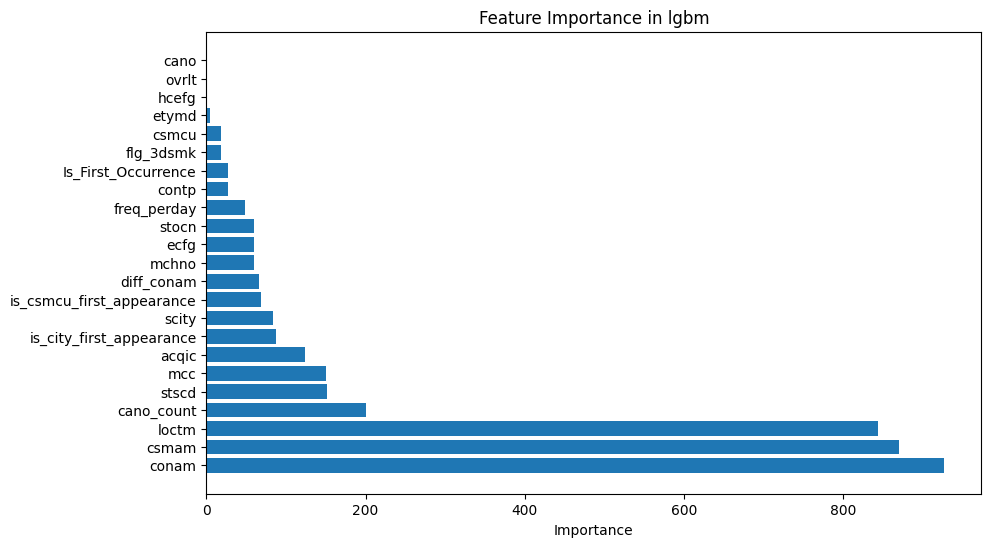

In [23]:
# Light GBM 
feature_importance_in_lgbm = bst.feature_importance(importance_type = 'split')  # 或 'gain'，取決於你想要的類型

# 獲取特徵名稱
feature_names_in_lgbm = bst.feature_name()

# 將特徵重要性轉換為 DataFrame
feature_importance_df_lgbm = pd.DataFrame({'Feature': feature_names_in_lgbm, 
                                           'Importance': feature_importance_in_lgbm}
                                           )

# 依照特徵重要性降序排序
feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values(by = 'Importance', ascending = False)

# 繪製特徵重要性圖表
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df_lgbm['Feature'], 
         feature_importance_df_lgbm['Importance']
         )

plt.xlabel('Importance')
plt.title('Feature Importance in lgbm')
plt.show()

In [24]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_train):
    # Change column type to float64 for column: 'flg_3dsmk'
    X_train = X_train.astype({'flg_3dsmk': 'float64'})
    # Replace missing values with 0 in column: 'flg_3dsmk'
    X_train = X_train.fillna({'flg_3dsmk': 0})
    # Replace gaps forward from the previous valid value in: 'csmam'
    X_train = X_train.fillna({'csmam': X_train['csmam'].ffill()})
    return X_train

X_train = clean_data(X_train.copy())
# X_train.head()

In [25]:
# random forest 

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 20231123, 
                                       n_jobs = 12
                                       )
rf_classifier.fit(X_train, y_train)

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=20231123)

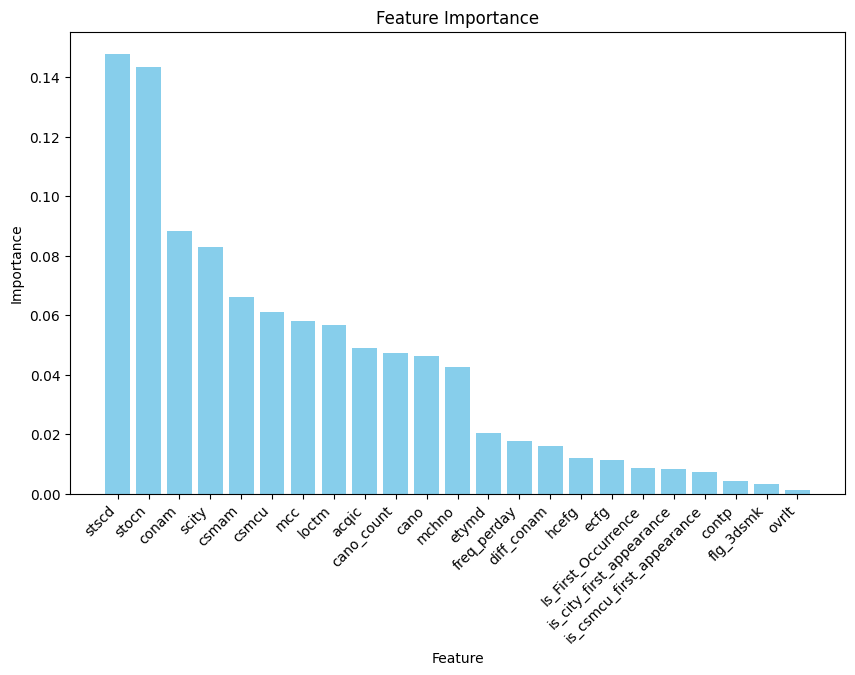

In [26]:
# Random forest 
feature_importance_in_rf = rf_classifier.feature_importances_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_in_rf
})

# 將 DataFrame 按照重要性排序
feature_importance_df_rf = feature_importance_df_rf.sort_values(by = 'Importance', ascending = False)

# 繪製條形圖
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color = 'skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # 如果特徵名稱較多，可以旋轉 x 軸標籤
plt.show()

In [27]:
# # XGboost 

# y_train = y_train.astype(dtype = 'int')
# y_test = y_test.astype(dtype = 'int')

# xgb_model = xgb.XGBClassifier(
#     learning_rate=0.05,
#     n_estimators=300,
#     gamma=0,
#     subsample=0.8,
#     max_depth = 5,
#     colsample_bytree=0.8,
#     objective='binary:logistic',
#     n_jobs = 12,
#     scale_pos_weight=1,
#     seed=20231121,
#     enable_categorical=True,
#     tree_method='hist'
# )

# xgb_model.fit(X_train, y_train)


# import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 定義參數空間
param_dist = {
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(300, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 5)
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=12,
    seed=20231121,
    enable_categorical=True,
    tree_method='hist'
)

# 使用隨機搜索進行參數調優
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    verbose=1, 
    n_jobs=-1, 
    random_state=20231121,
    scoring='f1'
)

# 擬合模型
random_search.fit(X_train, y_train, 
                  eval_set=[(X_test, y_test)], 
                  early_stopping_rounds=50,
                  eval_metric='auc',
                  verbose=True)

# 獲取最佳模型
best_xgb_model = random_search.best_estimator_

# 打印最佳參數
print("Best parameters found: ", random_search.best_params_)

# 使用最佳模型進行預測
y_pred = best_xgb_model.predict(X_test)
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# 評估模型
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("AUC-ROC score:", roc_auc_score(y_test, y_prob))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-auc:0.34984
[1]	validation_0-auc:0.36340
[2]	validation_0-auc:0.58375
[3]	validation_0-auc:0.58593
[4]	validation_0-auc:0.57118


c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.53838
[6]	validation_0-auc:0.60856
[7]	validation_0-auc:0.55250
[8]	validation_0-auc:0.56864
[9]	validation_0-auc:0.53917
[10]	validation_0-auc:0.52969
[11]	validation_0-auc:0.61612
[12]	validation_0-auc:0.68953
[13]	validation_0-auc:0.68532
[14]	validation_0-auc:0.65493
[15]	validation_0-auc:0.69950
[16]	validation_0-auc:0.68297
[17]	validation_0-auc:0.70631
[18]	validation_0-auc:0.71818
[19]	validation_0-auc:0.72384
[20]	validation_0-auc:0.71861
[21]	validation_0-auc:0.72400
[22]	validation_0-auc:0.73431
[23]	validation_0-auc:0.72537
[24]	validation_0-auc:0.72840
[25]	validation_0-auc:0.71942
[26]	validation_0-auc:0.72625
[27]	validation_0-auc:0.72947
[28]	validation_0-auc:0.72557
[29]	validation_0-auc:0.73409
[30]	validation_0-auc:0.73747
[31]	validation_0-auc:0.74084
[32]	validation_0-auc:0.74851
[33]	validation_0-auc:0.73544
[34]	validation_0-auc:0.73988
[35]	validation_0-auc:0.73784
[36]	validation_0-auc:0.73651
[37]	validation_0-auc:0.74429
[38]	validation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

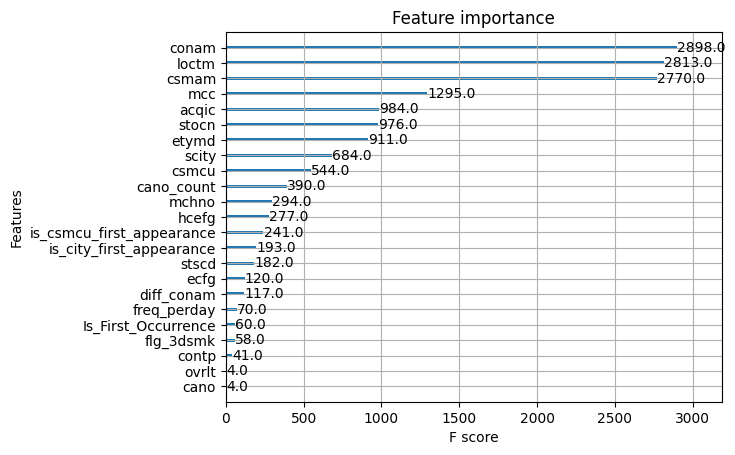

In [28]:
# XG boost
plot_importance(best_xgb_model)

#### Feature importance in 3  model

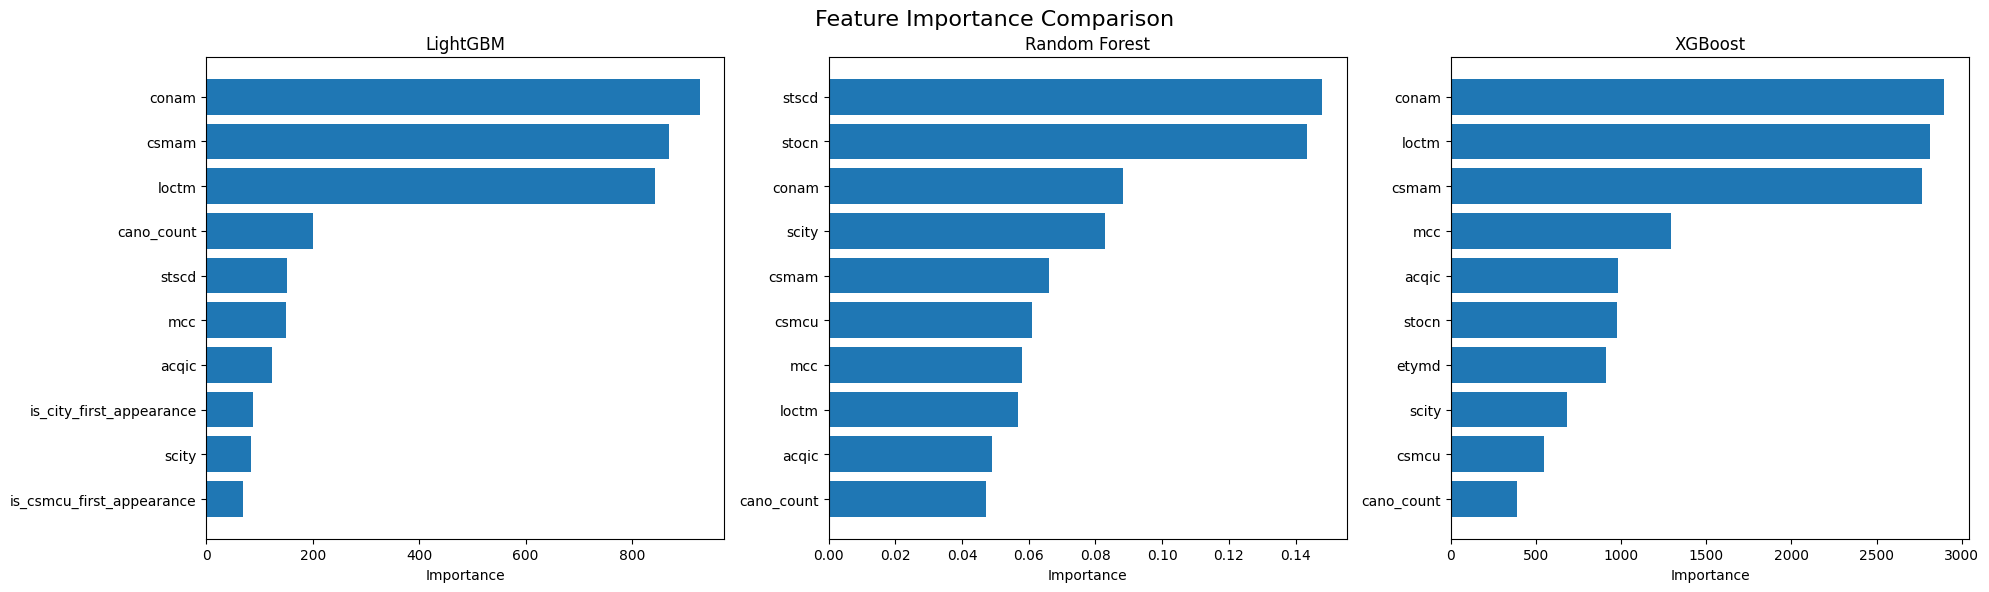

In [29]:
# LightGBM
feature_importance_df_lgbm = pd.DataFrame({
    'Feature': feature_names_in_lgbm,
    'Importance': feature_importance_in_lgbm
}).sort_values(by = 'Importance', ascending = True)

# Random Forest
feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_in_rf
}).sort_values(by = 'Importance', ascending = True)

# XGBoost (使用 plot_importance 函數的數據)
fig_xgb, ax_xgb = plt.subplots(figsize=(10, 10))
plot_importance(best_xgb_model, ax = ax_xgb, importance_type = 'weight')
plt.close(fig_xgb)  # 關閉 XGBoost 的單獨圖表

# 從 ax_xgb 
xgb_importance = [patch.get_width() for patch in ax_xgb.patches]
xgb_features = [text.get_text() for text in ax_xgb.get_yticklabels()]

feature_importance_df_xgb = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_importance
}).sort_values(by = 'Importance', ascending = True)


# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
fig.suptitle('Feature Importance Comparison', fontsize = 16)

# LightGBM
ax1.barh(feature_importance_df_lgbm['Feature'].tail(10), feature_importance_df_lgbm['Importance'].tail(10))
ax1.set_title('LightGBM')
ax1.set_xlabel('Importance')

# Random Forest
ax2.barh(feature_importance_df_rf['Feature'].tail(10), feature_importance_df_rf['Importance'].tail(10))
ax2.set_title('Random Forest')
ax2.set_xlabel('Importance')

# XGBoost
ax3.barh(feature_importance_df_xgb['Feature'].tail(10), feature_importance_df_xgb['Importance'].tail(10))
ax3.set_title('XGBoost')
ax3.set_xlabel('Importance')

# adjust layout
plt.tight_layout()
plt.subplots_adjust(top = 0.9)

plt.show()

#### Model prediction

In [30]:
y_probabilities_lgbm = bst.predict(X_test, num_iteration = bst.best_iteration)
y_probabilities_rf = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)
y_probabilities_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

LightGBM - Best Threshold: 0.47, Best F1: 0.7500
XGBoost - Best Threshold: 0.98, Best F1: 0.3721
Random Forest - Best Threshold: 0.34, Best F1: 0.7737


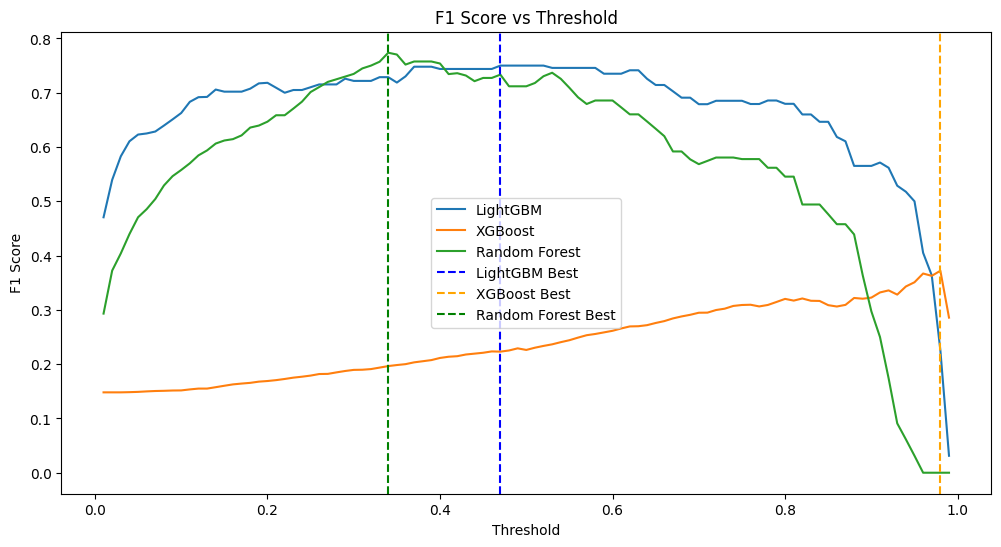

LightGBM - Precision: 0.7895, Recall: 0.7143
XGBoost - Precision: 0.2936, Recall: 0.5079
Random Forest - Precision: 0.7162, Recall: 0.8413
Best common threshold: 0.53
LightGBM (Common Threshold) - Precision: 0.8000, Recall: 0.6984, F1: 0.7458
XGBoost (Common Threshold) - Precision: 0.1360, Recall: 0.9048, F1: 0.2365
Random Forest (Common Threshold) - Precision: 0.8235, Recall: 0.6667, F1: 0.7368


In [31]:
def find_best_threshold(y_true, y_prob, thresholds):
    best_f1 = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# 使用更精細的閾值範圍
thresholds = np.arange(0.01, 1, 0.01)

# 找到每個模型的最佳閾值
best_threshold_lgbm, best_f1_lgbm = find_best_threshold(y_test.label, y_probabilities_lgbm, thresholds)
best_threshold_xgb, best_f1_xgb = find_best_threshold(y_test.label, y_probabilities_xgb, thresholds)
best_threshold_rf, best_f1_rf = find_best_threshold(y_test.label, y_probabilities_rf, thresholds)

print(f"LightGBM - Best Threshold: {best_threshold_lgbm:.2f}, Best F1: {best_f1_lgbm:.4f}")
print(f"XGBoost - Best Threshold: {best_threshold_xgb:.2f}, Best F1: {best_f1_xgb:.4f}")
print(f"Random Forest - Best Threshold: {best_threshold_rf:.2f}, Best F1: {best_f1_rf:.4f}")

# 計算並繪製各個閾值下的F1分數
f1_scores_lgbm = [f1_score(y_test.label, (y_probabilities_lgbm >= t).astype(int)) for t in thresholds]
f1_scores_xgb = [f1_score(y_test.label, (y_probabilities_xgb >= t).astype(int)) for t in thresholds]
f1_scores_rf = [f1_score(y_test.label, (y_probabilities_rf >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores_lgbm, label='LightGBM')
plt.plot(thresholds, f1_scores_xgb, label='XGBoost')
plt.plot(thresholds, f1_scores_rf, label='Random Forest')
plt.axvline(x=best_threshold_lgbm, color='blue', linestyle='--', label='LightGBM Best')
plt.axvline(x=best_threshold_xgb, color='orange', linestyle='--', label='XGBoost Best')
plt.axvline(x=best_threshold_rf, color='green', linestyle='--', label='Random Forest Best')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 計算並打印最佳閾值下的精確率和召回率
precision_lgbm = precision_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))
recall_lgbm = recall_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))

precision_xgb = precision_score(y_test.label, (y_probabilities_xgb >= best_threshold_xgb).astype(int))
recall_xgb = recall_score(y_test.label, (y_probabilities_xgb >= best_threshold_xgb).astype(int))

precision_rf = precision_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))
recall_rf = recall_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))

print(f"LightGBM - Precision: {precision_lgbm:.4f}, Recall: {recall_lgbm:.4f}")
print(f"XGBoost - Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")

# 找到一個共同的閾值
common_thresholds = np.arange(0.3, 0.7, 0.01)  # 可以根據需要調整範圍
f1_scores_common = []

for threshold in common_thresholds:
    f1_lgbm = f1_score(y_test.label, (y_probabilities_lgbm >= threshold).astype(int))
    f1_xgb = f1_score(y_test.label, (y_probabilities_xgb >= threshold).astype(int))
    f1_rf = f1_score(y_test.label, (y_probabilities_rf >= threshold).astype(int))
    avg_f1 = (f1_lgbm + f1_xgb + f1_rf) / 3
    f1_scores_common.append(avg_f1)

best_common_threshold = common_thresholds[np.argmax(f1_scores_common)]
print(f"Best common threshold: {best_common_threshold:.2f}")

# 計算並打印使用共同閾值的結果
for model_name, y_prob in [('LightGBM', y_probabilities_lgbm), 
                           ('XGBoost', y_probabilities_xgb), 
                           ('Random Forest', y_probabilities_rf)]:
    y_pred = (y_prob >= best_common_threshold).astype(int)
    precision = precision_score(y_test.label, y_pred)
    recall = recall_score(y_test.label, y_pred)
    f1 = f1_score(y_test.label, y_pred)
    print(f"{model_name} (Common Threshold) - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

LightGBM - Best Threshold: 0.47, Best F1: 0.7500
Random Forest - Best Threshold: 0.34, Best F1: 0.7737


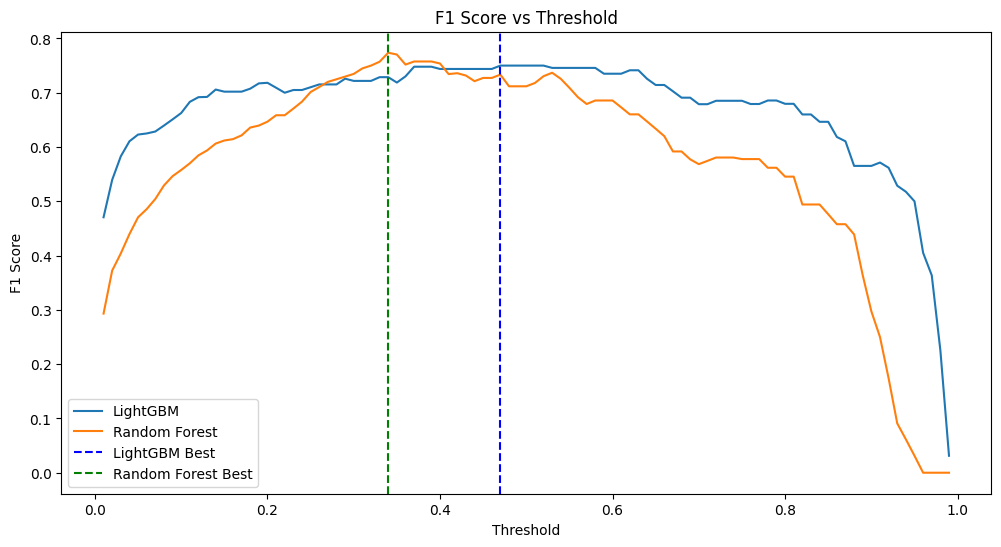

LightGBM - Precision: 0.7895, Recall: 0.7143
Random Forest - Precision: 0.7162, Recall: 0.8413
Best common threshold: 0.37
LightGBM (Common Threshold) - Precision: 0.7667, Recall: 0.7302, F1: 0.7480
Random Forest (Common Threshold) - Precision: 0.7246, Recall: 0.7937, F1: 0.7576


In [32]:
def find_best_threshold(y_true, y_prob, thresholds):
    best_f1 = 0
    best_threshold = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# 使用更精細的閾值範圍
thresholds = np.arange(0.01, 1, 0.01)

# 找到每個模型的最佳閾值
best_threshold_lgbm, best_f1_lgbm = find_best_threshold(y_test.label, y_probabilities_lgbm, thresholds)
best_threshold_rf, best_f1_rf = find_best_threshold(y_test.label, y_probabilities_rf, thresholds)

print(f"LightGBM - Best Threshold: {best_threshold_lgbm:.2f}, Best F1: {best_f1_lgbm:.4f}")
print(f"Random Forest - Best Threshold: {best_threshold_rf:.2f}, Best F1: {best_f1_rf:.4f}")

# 計算並繪製各個閾值下的F1分數
f1_scores_lgbm = [f1_score(y_test.label, (y_probabilities_lgbm >= t).astype(int)) for t in thresholds]
f1_scores_rf = [f1_score(y_test.label, (y_probabilities_rf >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores_lgbm, label='LightGBM')
plt.plot(thresholds, f1_scores_rf, label='Random Forest')
plt.axvline(x=best_threshold_lgbm, color='blue', linestyle='--', label='LightGBM Best')
plt.axvline(x=best_threshold_rf, color='green', linestyle='--', label='Random Forest Best')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 計算並打印最佳閾值下的精確率和召回率
precision_lgbm = precision_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))
recall_lgbm = recall_score(y_test.label, (y_probabilities_lgbm >= best_threshold_lgbm).astype(int))

precision_rf = precision_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))
recall_rf = recall_score(y_test.label, (y_probabilities_rf >= best_threshold_rf).astype(int))

print(f"LightGBM - Precision: {precision_lgbm:.4f}, Recall: {recall_lgbm:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")

# 找到一個共同的閾值
common_thresholds = np.arange(0.3, 0.7, 0.01)  # 可以根據需要調整範圍
f1_scores_common = []

for threshold in common_thresholds:
    f1_lgbm = f1_score(y_test.label, (y_probabilities_lgbm >= threshold).astype(int))
    f1_rf = f1_score(y_test.label, (y_probabilities_rf >= threshold).astype(int))
    avg_f1 = (f1_lgbm + f1_rf) / 2
    f1_scores_common.append(avg_f1)

best_common_threshold = common_thresholds[np.argmax(f1_scores_common)]
print(f"Best common threshold: {best_common_threshold:.2f}")

# 計算並打印使用共同閾值的結果
for model_name, y_prob in [('LightGBM', y_probabilities_lgbm), 
                           ('Random Forest', y_probabilities_rf)]:
    y_pred = (y_prob >= best_common_threshold).astype(int)
    precision = precision_score(y_test.label, y_pred)
    recall = recall_score(y_test.label, y_pred)
    f1 = f1_score(y_test.label, y_pred)
    print(f"{model_name} (Common Threshold) - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

The max F1 score of LightGBM is 0.7500000000000001
The max F1 score of Random Forest is 0.7737226277372262
The max F1 score of XGBoost is 0.37209302325581395

Best threshold for LightGBM: 0.47000000000000003
Best threshold for Random Forest: 0.34
Best threshold for XGBoost: 0.98


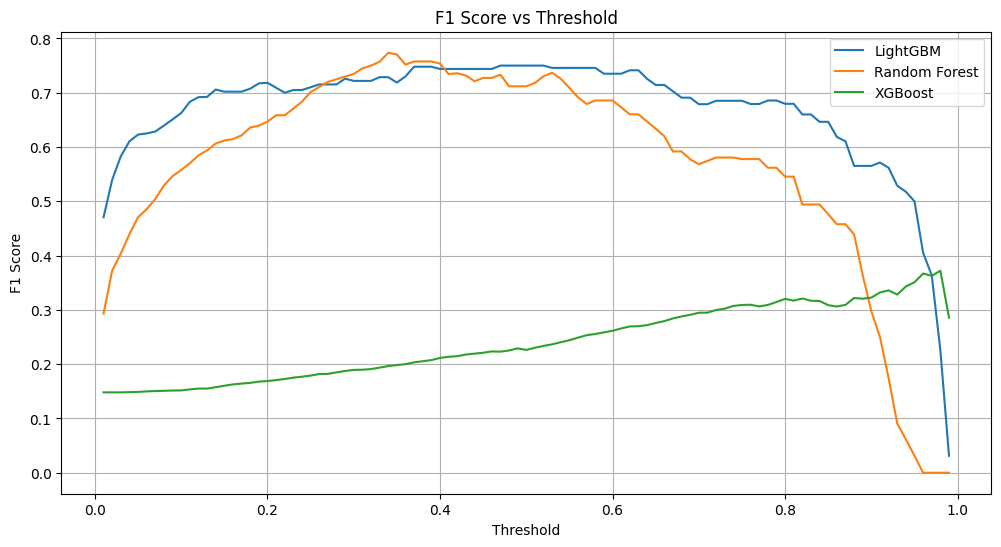

In [33]:
# 確保我們有一個閾值範圍
thresholds = np.arange(0.01, 1, 0.01)

# 為每個模型和每個閾值計算 F1 分數
f1_scores_lgbm = [f1_score(y_test.label, (y_probabilities_lgbm >= threshold).astype(int)) for threshold in thresholds]
f1_scores_rf = [f1_score(y_test.label, (y_probabilities_rf >= threshold).astype(int)) for threshold in thresholds]
f1_scores_xgb = [f1_score(y_test.label, (y_probabilities_xgb >= threshold).astype(int)) for threshold in thresholds]

# 打印最大 F1 分數
print(f"The max F1 score of LightGBM is {max(f1_scores_lgbm)}")
print(f"The max F1 score of Random Forest is {max(f1_scores_rf)}")
print(f"The max F1 score of XGBoost is {max(f1_scores_xgb)}")

# 找到對應最大 F1 分數的閾值
best_threshold_lgbm = thresholds[np.argmax(f1_scores_lgbm)]
best_threshold_rf = thresholds[np.argmax(f1_scores_rf)]
best_threshold_xgb = thresholds[np.argmax(f1_scores_xgb)]

print(f"\nBest threshold for LightGBM: {best_threshold_lgbm}")
print(f"Best threshold for Random Forest: {best_threshold_rf}")
print(f"Best threshold for XGBoost: {best_threshold_xgb}")

# 可視化 F1 分數隨閾值變化的曲線
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_scores_lgbm, label='LightGBM')
plt.plot(thresholds, f1_scores_rf, label='Random Forest')
plt.plot(thresholds, f1_scores_xgb, label='XGBoost')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

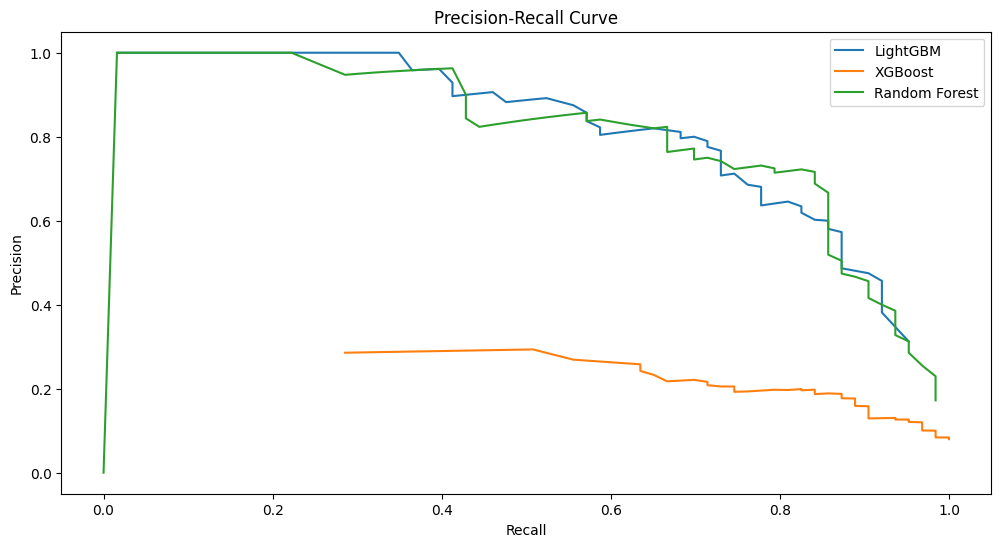

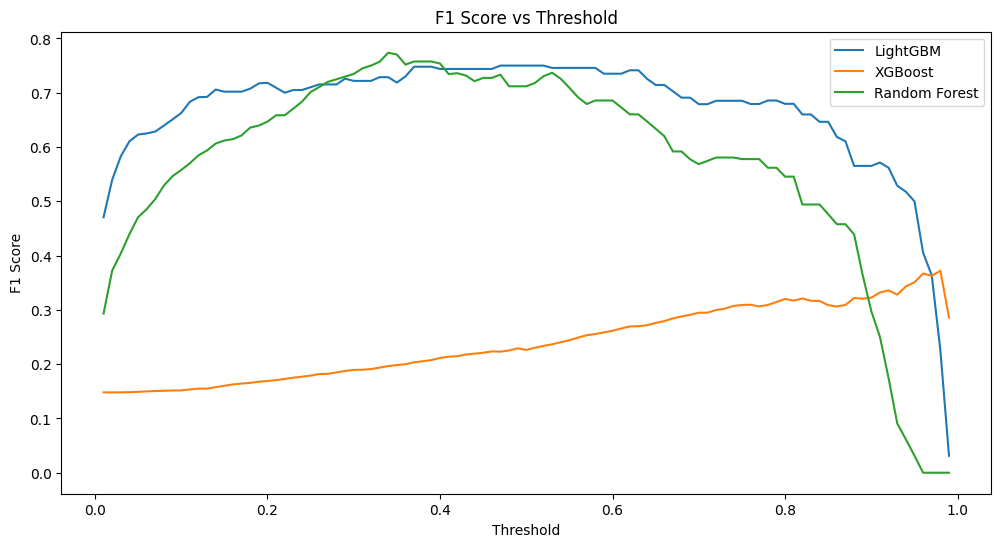

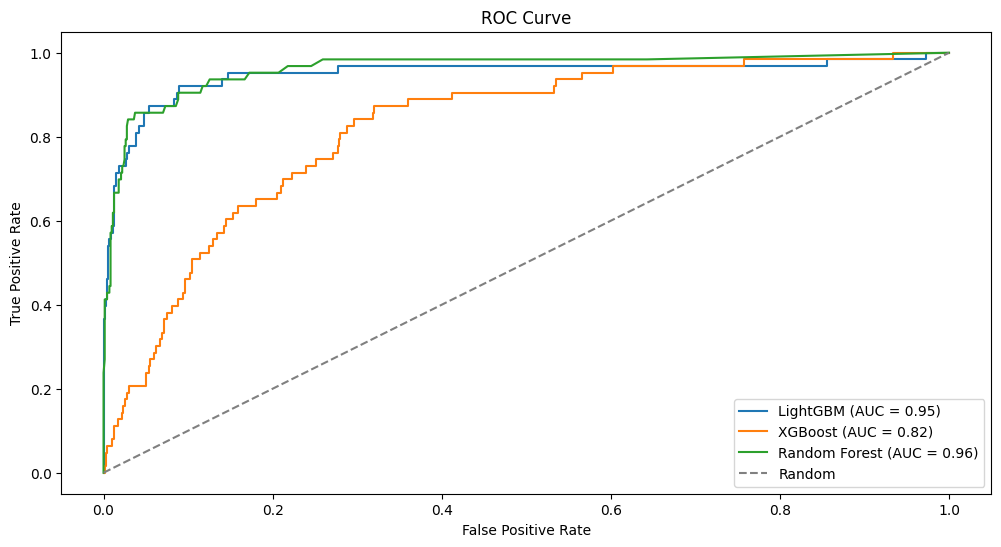

In [35]:
# model prediction
y_probabilities_lgbm = bst.predict(X_test, num_iteration = bst.best_iteration)
y_probabilities_rf = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)
y_probabilities_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# # scatter for 3 model
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 6))

# # LightGBM scatter
# scatter1 = ax1.scatter(range(len(y_test)), y_probabilities_lgbm, c=y_test.label, cmap='viridis', alpha=0.7)
# ax1.set_title('Scatter Plot of Probabilities in LightGBM')
# ax1.set_xlabel('Sample Index')
# ax1.set_ylabel('Probability')
# fig.colorbar(scatter1, ax=ax1, label='True Label')

# # XGBoost scatter
# scatter2 = ax2.scatter(range(len(y_test)), y_probabilities_xgb, c=y_test.label, cmap='viridis', alpha=0.7)
# ax2.set_title('Scatter Plot of Probabilities in XGBoost')
# ax2.set_xlabel('Sample Index')
# ax2.set_ylabel('Probability')
# fig.colorbar(scatter2, ax=ax2, label='True Label')

# # Random Forest scatter
# scatter3 = ax3.scatter(range(len(y_test)), y_probabilities_rf, c=y_test.label, cmap='viridis', alpha=0.7)
# ax3.set_title('Scatter Plot of Probabilities in Random Forest')
# ax3.set_xlabel('Sample Index')
# ax3.set_ylabel('Probability')
# fig.colorbar(scatter3, ax = ax3, label='True Label')

# plt.tight_layout()
# plt.show()

# 計算不同閾值下的評估指標
thresholds = np.arange(0.01, 1, 0.01)

# 函數來計算評估指標
def calculate_metrics(y_true, y_prob, thresholds):
    predictions = [(y_prob >= threshold).astype(int) for threshold in thresholds]
    precision_values = [precision_score(y_true, prediction) for prediction in predictions]
    recall_values = [recall_score(y_true, prediction) for prediction in predictions]
    f1_values = [f1_score(y_true, prediction) for prediction in predictions]
    return precision_values, recall_values, f1_values

# 計算各模型的評估指標
precision_lgbm, recall_lgbm, f1_lgbm = calculate_metrics(y_test.label, y_probabilities_lgbm, thresholds)
precision_xgb, recall_xgb, f1_xgb = calculate_metrics(y_test.label, y_probabilities_xgb, thresholds)
precision_rf, recall_rf, f1_rf = calculate_metrics(y_test.label, y_probabilities_rf, thresholds)

# 繪製 Precision-Recall 曲線
plt.figure(figsize=(12, 6))
plt.plot(recall_lgbm, precision_lgbm, label='LightGBM')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 分數曲線
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_lgbm, label='LightGBM')
plt.plot(thresholds, f1_xgb, label='XGBoost')
plt.plot(thresholds, f1_rf, label='Random Forest')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 計算並繪製 ROC 曲線
plt.figure(figsize=(12, 6))
for y_prob, model_name in zip([y_probabilities_lgbm, y_probabilities_xgb, y_probabilities_rf],
                              ['LightGBM', 'XGBoost', 'Random Forest']):
    fpr, tpr, _ = roc_curve(y_test.label, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Max f1-score in 3 model

In [36]:
print(f"The max F1 score of lgbm is {max(f1_lgbm)}")
print(f"The max F1 score of RF is {max(f1_rf)}")
print(f"The max F1 score of Xgb is {max(f1_xgb)}")

The max F1 score of lgbm is 0.7500000000000001
The max F1 score of RF is 0.7737226277372262
The max F1 score of Xgb is 0.31460674157303364


#### Integrated all the result

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

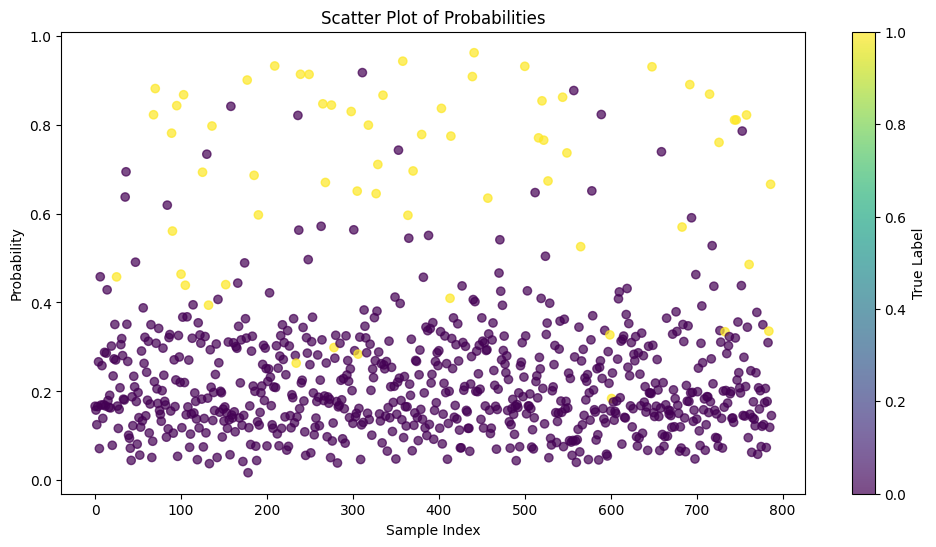

In [32]:
# Integrated all the result
y_probabilities_xgb_train = xgb_model.predict_proba(X_test)[:,1]

y_probabilities_lgbm_train = bst.predict(X_test, 
                                         num_iteration = bst.best_iteration
                                         )

y_probabilities_rf_train = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities = (y_probabilities_rf_train + y_probabilities_lgbm_train + y_probabilities_xgb_train) / 3


plt.figure(figsize = (12, 6))
plt.scatter(range(len(y_test)), 
            y_probabilities, 
            c =  y_test.label, 
            cmap = 'viridis', 
            alpha = 0.7
            )

plt.colorbar(label = 'True Label')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.show()

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


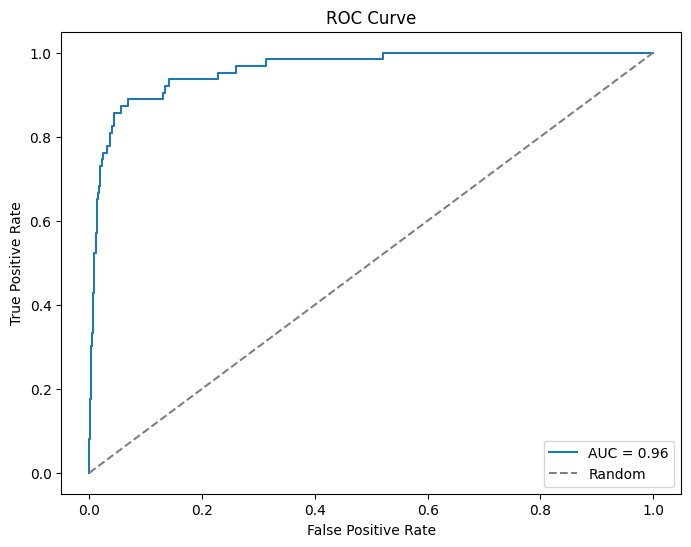

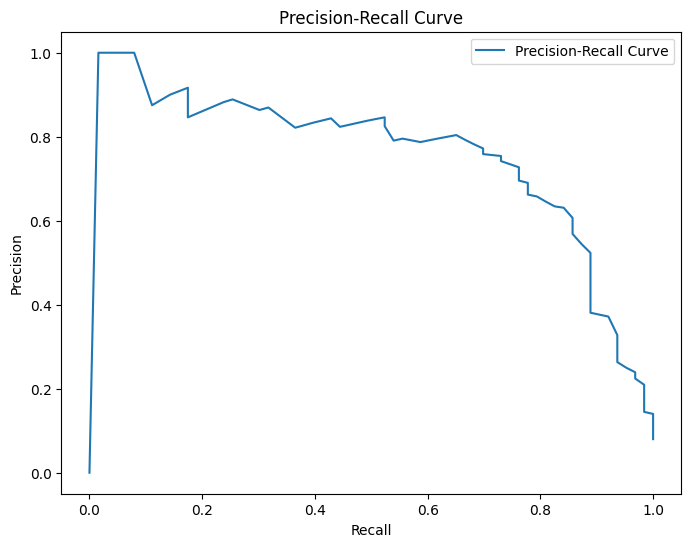

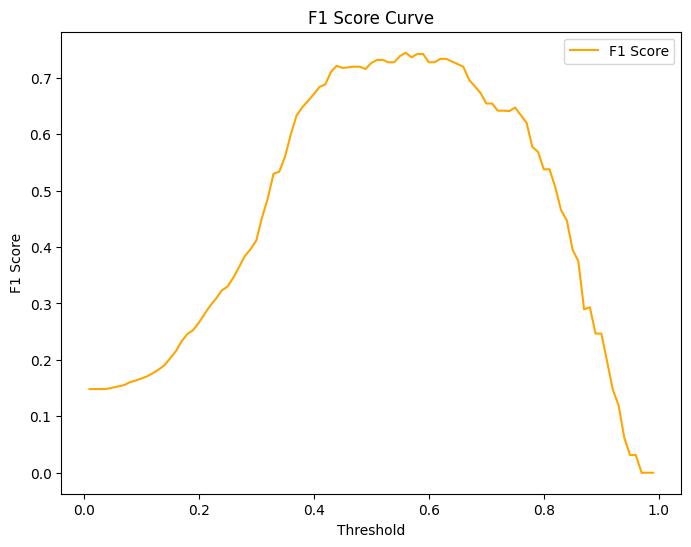

In [33]:
thresholds = np.arange(0.01, 1, 0.01)
predictions = [(y_probabilities >= threshold).astype(int) for threshold in thresholds]
precision_values = [precision_score(y_test.label, prediction) for prediction in predictions]
recall_values = [recall_score(y_test.label, prediction) for prediction in predictions]
f1_values = [f1_score(y_test.label, y_probabilities >= threshold) for threshold in thresholds]

# 計算 ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test.label, y_probabilities)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 繪製 precision-recall 曲線
plt.figure(figsize = (8, 6))
plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 score 曲線
plt.figure(figsize = (8, 6))
plt.plot(thresholds, f1_values, label='F1 Score', color='orange')
plt.title('F1 Score Curve')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [34]:
print(f"The max F1 score of emsemble result is {max(f1_values)}")

The max F1 score of emsemble result is 0.7441860465116279


In [35]:
thresholds[np.argmax(f1_values)]

0.56

看看上面那個是在做啥

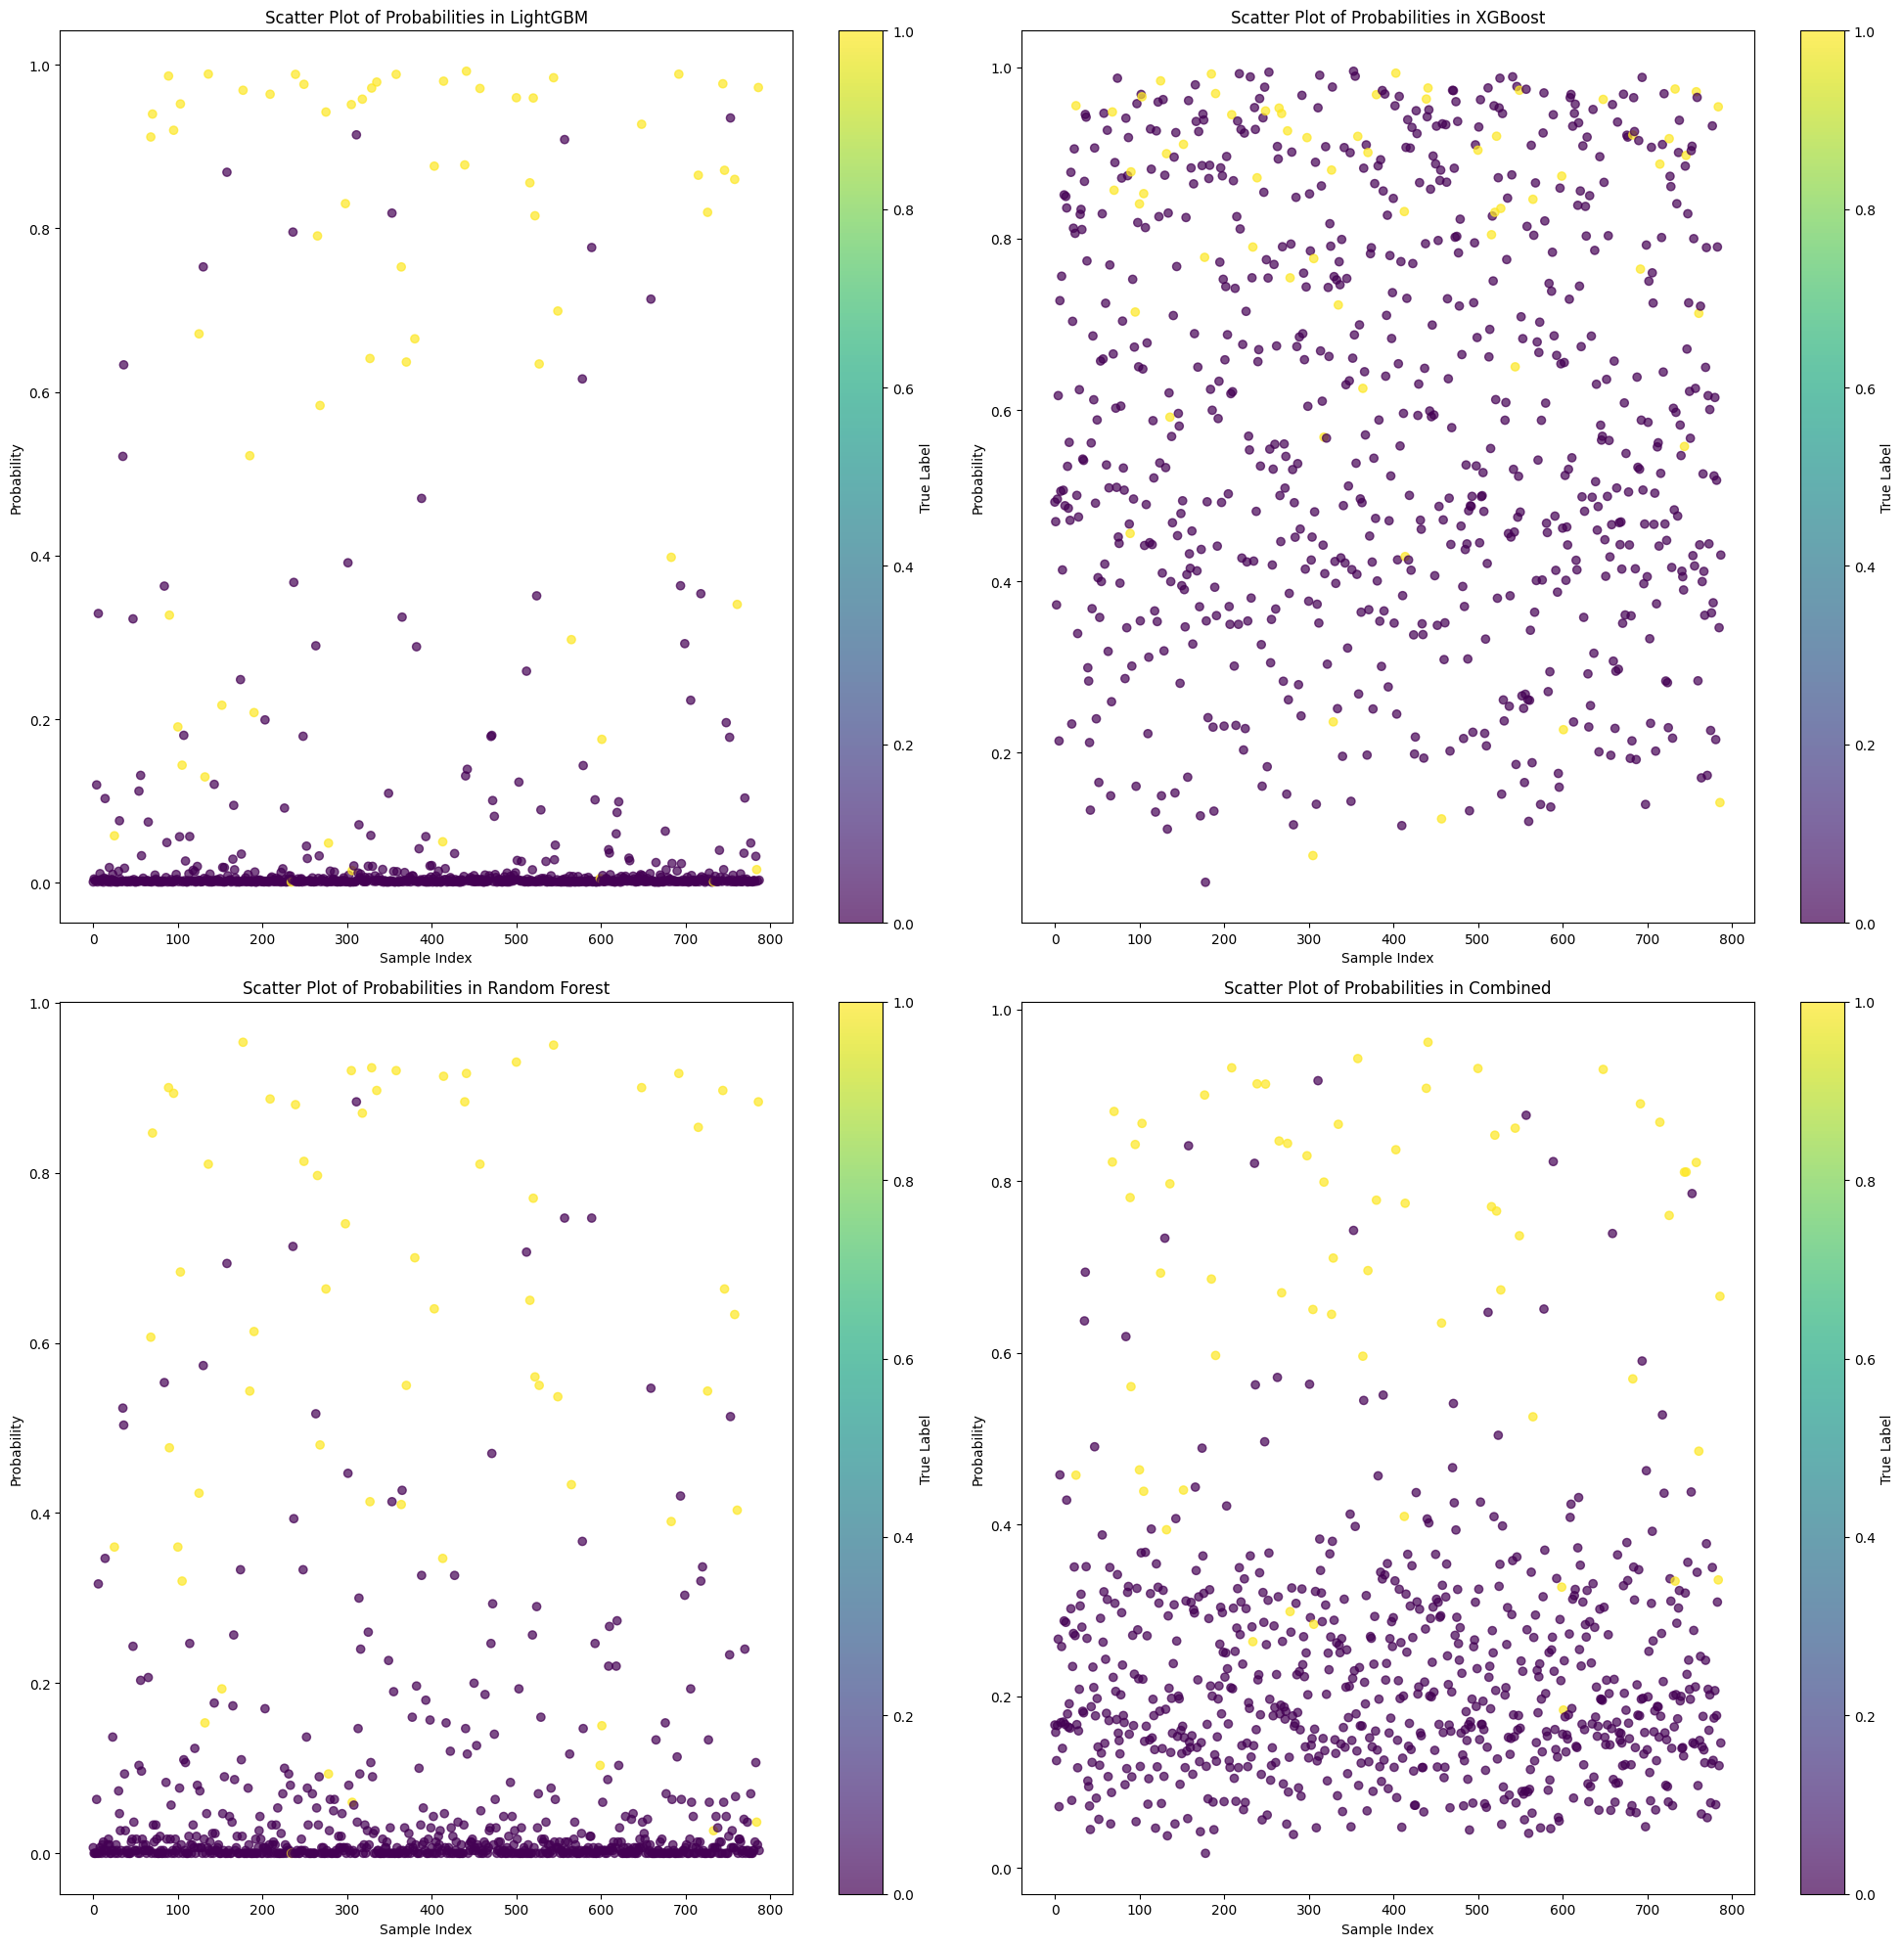

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\J

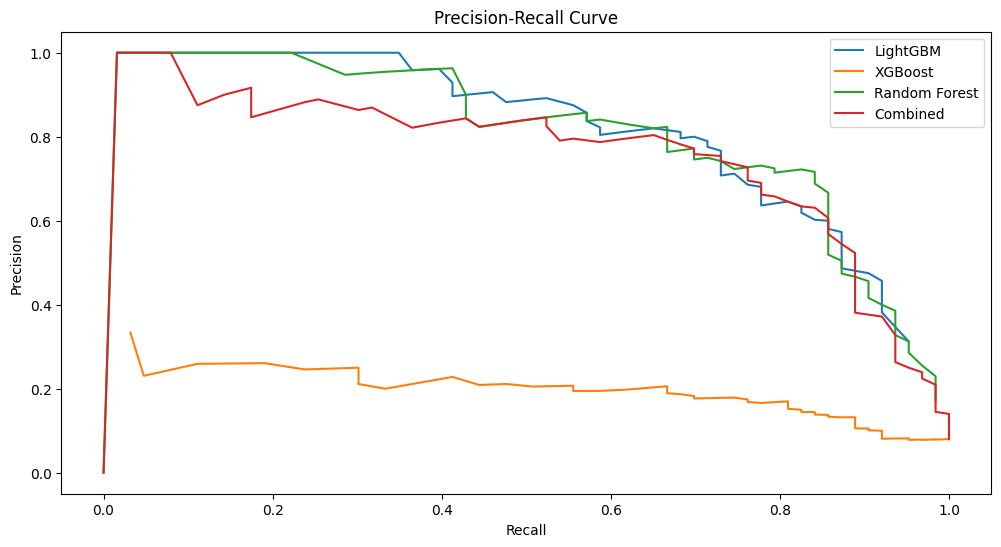

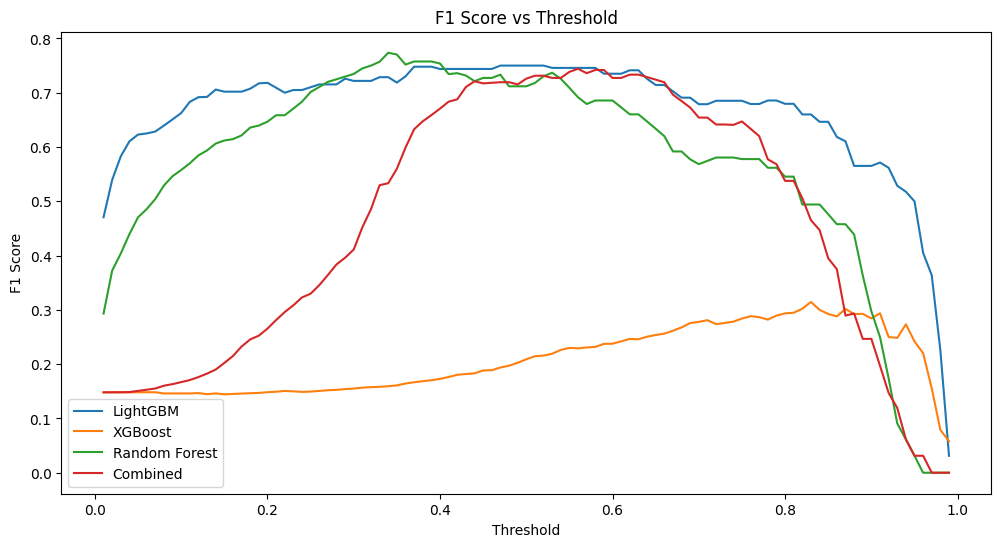

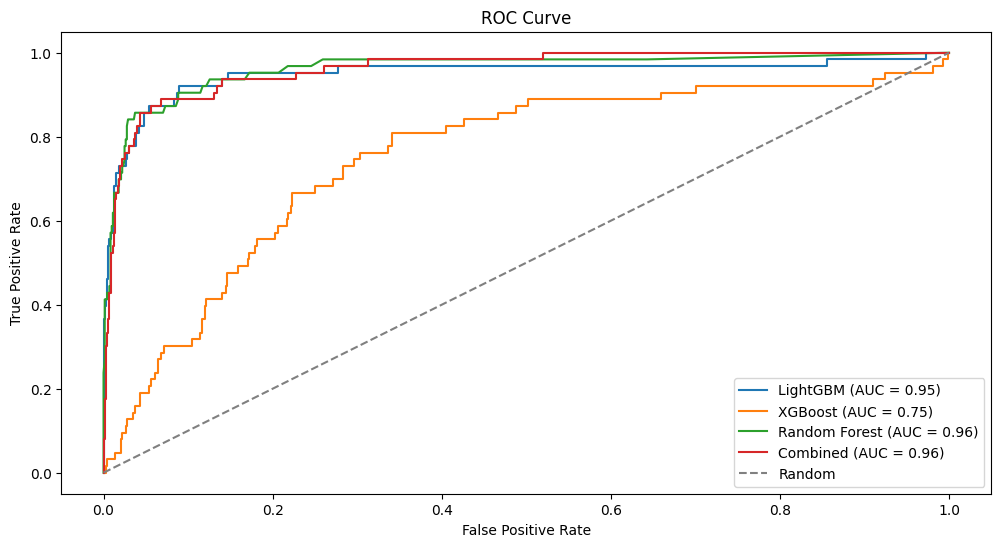

In [36]:
y_probabilities_combined = (y_probabilities_rf + y_probabilities_lgbm + y_probabilities_xgb) / 3

# 繪製散點圖
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
models = [('LightGBM', y_probabilities_lgbm), 
          ('XGBoost', y_probabilities_xgb), 
          ('Random Forest', y_probabilities_rf),
          ('Combined', y_probabilities_combined)]

for i, (model_name, y_prob) in enumerate(models):
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(range(len(y_test)), y_prob, c=y_test.label, cmap='viridis', alpha=0.7)
    ax.set_title(f'Scatter Plot of Probabilities in {model_name}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Probability')
    fig.colorbar(scatter, ax=ax, label='True Label')

plt.tight_layout()
plt.show()

# 計算評估指標的函數
def calculate_metrics(y_true, y_prob, thresholds):
    predictions = [(y_prob >= threshold).astype(int) for threshold in thresholds]
    precision_values = [precision_score(y_true, prediction) for prediction in predictions]
    recall_values = [recall_score(y_true, prediction) for prediction in predictions]
    f1_values = [f1_score(y_true, prediction) for prediction in predictions]
    return precision_values, recall_values, f1_values

# 計算各模型的評估指標
thresholds = np.arange(0.01, 1, 0.01)
metrics = {}
for model_name, y_prob in models:
    metrics[model_name] = calculate_metrics(y_test.label, y_prob, thresholds)

# 繪製 Precision-Recall 曲線
plt.figure(figsize=(12, 6))
for model_name, (precision, recall, _) in metrics.items():
    plt.plot(recall, precision, label=model_name)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 分數曲線
plt.figure(figsize=(12, 6))
for model_name, (_, _, f1) in metrics.items():
    plt.plot(thresholds, f1, label=model_name)
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 繪製 ROC 曲線
plt.figure(figsize=(12, 6))
for model_name, y_prob in models:
    fpr, tpr, _ = roc_curve(y_test.label, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 記得用一下grid search

In [37]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import xgboost as xgb

# # 假设您已经有了数据集 X 和目标变量 y
# # X = ...
# # y = ...

# # 分割数据集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 创建 XGBoost 回归器对象
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # 定义参数网格
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200, 300],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.7, 0.8, 0.9]
# }

# # 创建 GridSearchCV 对象
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# # 执行网格搜索
# grid_search.fit(X_train, y_train)

# # 输出最佳参数和得分
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", -grid_search.best_score_)

# # 使用最佳参数的模型进行预测
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 计算测试集上的均方误差
# mse = mean_squared_error(y_test, y_pred)
# print("Mean squared error on test set: ", mse)

# # 特征重要性
# feature_importance = best_model.feature_importances_
# feature_names = X.columns
# importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
# importance_df = importance_df.sort_values('importance', ascending=False)
# print("\nFeature Importance:")
# print(importance_df)

## 4. Prediction on testing data

我們根據從 Step3 得到的模型以及最佳的 threshold 來對我們的 testing set 進行預測。

In [38]:
#Test set data
# etymd 補值 99 表示 NA, 
# mcc 用 999 表示 NA
# stocn 補值 999 表示 NA (600 筆有 25 筆 fraud)
# scity 用 999 表示 NA
# stscd 這個欄位非常重要，不能去除，因為在有狀態碼的資料中，有 50% 的資料是盜刷!，用 99 來當作 NA 的補值
# hcefg 補值 99 表示 NA
# csmcu 補值 99 表示 NA 

cols_test = df_raw_test.columns
[{f"{cols_test[i]}":df_raw_test[f'{cols_test[i]}'].isna().sum()} for i in range(len(cols_test))]


[{'txkey': 343},
 {'locdt': 304},
 {'loctm': 314},
 {'chid': 311},
 {'cano': 302},
 {'contp': 352},
 {'etymd': 362},
 {'mchno': 324},
 {'acqic': 330},
 {'mcc': 336},
 {'conam': 281},
 {'ecfg': 341},
 {'stocn': 324},
 {'scity': 353},
 {'stscd': 1911},
 {'ovrlt': 302},
 {'hcefg': 371},
 {'csmcu': 385},
 {'csmam': 307},
 {'flg_3dsmk': 0},
 {'diff_conam': 539},
 {'is_city_first_appearance': 0},
 {'is_csmcu_first_appearance': 0},
 {'cano_count': 302},
 {'Is_First_Occurrence': 0},
 {'freq_perday': 570}]

In [39]:
cols_test

Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')

In [40]:
# deal with test data
df_raw_test['etymd'] = df_raw_test['etymd'].fillna(99)
df_raw_test['stscd'] = df_raw_test['stscd'].fillna(99)

df_raw_test['stocn'] = df_raw_test['stocn'].fillna(999)
df_raw_test['hcefg'] = df_raw_test['hcefg'].fillna(999)
df_raw_test['csmcu'] = df_raw_test['csmcu'].fillna(999)
df_raw_test['mcc'] = df_raw_test['mcc'].fillna(999)
df_raw_test['scity'] = df_raw_test['scity'].fillna(999)

[{f"{cols_test[i]}":df_raw_test[f'{cols_test[i]}'].isna().sum()} for i in range(len(cols_test))]

[{'txkey': 343},
 {'locdt': 304},
 {'loctm': 314},
 {'chid': 311},
 {'cano': 302},
 {'contp': 352},
 {'etymd': 0},
 {'mchno': 324},
 {'acqic': 330},
 {'mcc': 0},
 {'conam': 281},
 {'ecfg': 341},
 {'stocn': 0},
 {'scity': 0},
 {'stscd': 0},
 {'ovrlt': 302},
 {'hcefg': 0},
 {'csmcu': 0},
 {'csmam': 307},
 {'flg_3dsmk': 0},
 {'diff_conam': 539},
 {'is_city_first_appearance': 0},
 {'is_csmcu_first_appearance': 0},
 {'cano_count': 302},
 {'Is_First_Occurrence': 0},
 {'freq_perday': 570}]

In [41]:
# 因為 map 過去後還是會遇到沒有對應值的情形，此時就會產生 NA，因此我們將 NA 都補值 (999)

df_raw_test['mchno'] = df_raw_test['mchno'].map(dict_mchno)
df_raw_test['acqic'] = df_raw_test['acqic'].map(dict_acqic)
df_raw_test['cano'] = df_raw_test['cano'].map(dict_cano)


In [42]:
df_raw_test['mchno'] = df_raw_test['mchno'].fillna(9999)
df_raw_test['acqic'] = df_raw_test['acqic'].fillna(9999)
df_raw_test['cano'] = df_raw_test['cano'].fillna(999)

In [43]:
# model fitting
X_test_pub = df_raw_test.drop(['txkey','locdt','chid'], 
                              axis = 1, inplace = False
                              )

X_test_pub = X_test_pub.astype(dtype = 'category')

In [44]:
print(X_test_pub.columns)

Index(['loctm', 'cano', 'contp', 'etymd', 'mchno', 'acqic', 'mcc', 'conam',
       'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt', 'hcefg', 'csmcu', 'csmam',
       'flg_3dsmk', 'diff_conam', 'is_city_first_appearance',
       'is_csmcu_first_appearance', 'cano_count', 'Is_First_Occurrence',
       'freq_perday'],
      dtype='object')


In [45]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(X_test_pub):
#     # Drop rows with missing data across all columns
#     X_test_pub = X_test_pub.dropna()
#     return X_test_pub

# X_test_pub = clean_data(X_test_pub.copy())

In [46]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_test_pub):
    # Change column type to float64 for column: 'freq_perday'
    X_test_pub = X_test_pub.astype({'freq_perday': 'float64'})
    # Change column type to float64 for column: 'cano_count'
    X_test_pub = X_test_pub.astype({'cano_count': 'float64'})
    # Change column type to float64 for column: 'loctm'
    X_test_pub = X_test_pub.astype({'loctm': 'float64'})
    return X_test_pub

X_test_pub = clean_data(X_test_pub.copy())
X_test_pub.head()

,loctm,cano,contp,etymd,mchno,acqic,mcc,conam,ecfg,stocn,...,hcefg,csmcu,csmam,flg_3dsmk,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
0,NaN,999.0,5.0,5.0,9999.0,300.0,406.0,76.839628,1.0,999.0,...,6.0,70.0,-329.356052,0.0,0.0,True,True,1.0,True,1.0
1,50236.0,999.0,5.0,8.0,1160.0,282.0,324.0,272.087939,1.0,40.0,...,999.0,29.0,84.482536,0.0,NaN,False,False,NaN,False,NaN
2,4104.0,999.0,5.0,8.0,748.0,227.0,326.0,1061.161690,1.0,999.0,...,6.0,999.0,1530.061345,0.0,NaN,False,False,NaN,False,NaN
3,101305.0,999.0,NaN,1.0,830.0,300.0,375.0,387.208488,0.0,0.0,...,6.0,70.0,54.312320,0.0,NaN,False,False,NaN,False,NaN
4,103356.0,999.0,5.0,99.0,1740.0,168.0,999.0,232.583468,NaN,126.0,...,0.0,999.0,48.464017,0.0,0.0,False,False,1.0,True,1.0


In [49]:
# 1. 檢查 'cano_count' 列的情況
print(X_test_pub['cano_count'].describe())
print("NaN 值的數量:", X_test_pub['cano_count'].isna().sum())
print("無限值的數量:", np.isinf(X_test_pub['cano_count']).sum())

# 2. 處理 NaN 和無限值
# 方法 A: 用 0 或其他適當的值填充 NaN 和無限值
X_test_pub['cano_count'] = X_test_pub['cano_count'].fillna(0)
X_test_pub['cano_count'] = X_test_pub['cano_count'].replace([np.inf, -np.inf], 0)

# 方法 B: 或者，如果你想刪除這些行
# X_test_pub = X_test_pub.dropna(subset=['cano_count'])
# X_test_pub = X_test_pub[~np.isinf(X_test_pub['cano_count'])]

# 3. 安全地轉換為整數類型
X_test_pub['cano_count'] = X_test_pub['cano_count'].astype('int')

# 4. 對其他列進行類似的處理
columns_to_convert = ['csmam', 'loctm', 'freq_perday']

for col in columns_to_convert:
    # 檢查並處理 NaN 和無限值
    X_test_pub[col] = X_test_pub[col].fillna(X_test_pub[col].median())  # 使用中位數填充 NaN
    X_test_pub[col] = X_test_pub[col].replace([np.inf, -np.inf], X_test_pub[col].median())  # 處理無限值
    
    # 根據需要轉換數據類型
    if col in ['csmam', 'freq_perday']:
        X_test_pub[col] = X_test_pub[col].astype('float')
    elif col in ['loctm']:
        X_test_pub[col] = X_test_pub[col].astype('int')

# 5. 確認轉換結果
print(X_test_pub[['cano_count', 'csmam', 'loctm', 'freq_perday']].dtypes)

count    2100.000000
mean        1.502857
std         2.268220
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
Name: cano_count, dtype: float64
NaN 值的數量: 0
無限值的數量: 0
cano_count       int32
csmam          float64
loctm            int32
freq_perday    float64
dtype: object


In [50]:
X_test_pub['conam'] = X_test_pub['conam'].astype('float')
# X_test_pub['iterm'] = X_test_pub['iterm'].astype('int')
# X_test_pub['flam1'] = X_test_pub['flam1'].astype('float')
X_test_pub['csmam'] = X_test_pub['csmam'].astype('float')
X_test_pub['cano_count'] = X_test_pub['cano_count'].astype('int')
X_test_pub['loctm'] = X_test_pub['loctm'].astype('int')
X_test_pub['freq_perday'] = X_test_pub['freq_perday'].astype('int')
X_test_pub['diff_conam'] = X_test_pub['diff_conam'].astype('float')


In [51]:
y_probabilities_lgbm = bst.predict(X_test_pub, 
                                   num_iteration = bst.best_iteration
                                   )

y_probabilities_rf = np.mean([estimator.predict_proba(X_test_pub)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities_xgb = xgb_model.predict_proba(X_test_pub)[:,1]

y_probabilities = (y_probabilities_lgbm + y_probabilities_rf + y_probabilities_xgb)/3

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

In [52]:
predictions = (y_probabilities >= 0.36).astype(int)
df_raw_test['label'] = predictions

In [53]:
# 從原始測試數據中提取 'txkey' 和 'pred' 列
df_out = df_raw_test[['txkey', 'label']]

# 創建新的數據框，只包含所需的列
df_final = pd.DataFrame({
    'index': range(len(df_out)),  # 從 0 開始的序列
    'label': df_out['label']  # 使用 'pred' 列的數據
})

# 設置數據框的索引從 1 開始
# df_final.index = range(0, len(df_final))

# 驗證結果
print(df_final.head(30))


    index  label
0       0      0
1       1      1
2       2      1
3       3      0
4       4      1
5       5      1
6       6      1
7       7      0
8       8      0
9       9      0
10     10      0
11     11      0
12     12      0
13     13      0
14     14      0
15     15      1
16     16      1
17     17      0
18     18      0
19     19      1
20     20      0
21     21      0
22     22      1
23     23      0
24     24      0
25     25      0
26     26      1
27     27      0
28     28      1
29     29      1


In [75]:
df_final.to_csv('RF+LightGBM+XG_test5_repair.csv', 
              index = False, 
              encoding = 'utf-8'
              )

In [70]:
df_out = df_raw_test[['label']]
df_out.to_csv('RF+LightGBM+XG_test5_repair.csv', 
              index = False, 
              encoding = 'utf-8'
              )

In [71]:
df_out

,label
0,0
1,1
2,1
3,0
4,1
...,...
2095,1
2096,0
2097,0
2098,0
